In [1]:
from Bio import Phylo
from Bio.Phylo.TreeConstruction import DistanceMatrix, DistanceTreeConstructor
from keyname import keyname as kn
from matplotlib import colors as mpl_colors
from teeplot import teeplot as tp

import Bio
import alifedata_phyloinformatics_convert as apc
import csv
import glob
import itertools
import json
import networkx as nx
import numpy as np
import pandas as pd
import scipy as sci
import seaborn as sns
import urllib.request as request
import io
from copy import deepcopy

from etlib.SortableTree.SortableTree import SortableTree
from etlib.PlotTools.PlotTools import enable_pretty_graphing
enable_pretty_graphing()

In [2]:
morphs = {x['stint']: x[' morph'][1:] for x in pd.read_csv('morphs_by_stint.csv').to_dict(orient='records')}

In [3]:
matrix = np.loadtxt("data/distance_matrix.matrix")
with open("data/stint_tags.json", 'r') as f:
    stint_tags = json.loads(f.read())

In [4]:
def to_tril(matrix):
    return [
        row[:row_idx] + [0.0]
        for row_idx, row in enumerate(matrix.tolist())
    ]

def fix_branch_length(root):
    if 'Inner' not in root.name:
        root.branch_length = 1
    else:
        root.branch_length = sum([x.branch_length for x in root]) / len([x.branch_length for x in root])
    for x in root:
        fix_branch_length(x)

In [5]:
linkage_matrix = sci.cluster.hierarchy.linkage(matrix)

In [6]:
dendropy_tree = apc.scipy_linkage_matrix_to_dendropy_tree(
    linkage_matrix,
    leaf_labels=['{} ({})'.format(str(x), morphs[x]) for x in range(len(linkage_matrix) + 1)]
)

In [7]:
df = apc.dendropy_tree_to_alife_dataframe(dendropy_tree)

In [8]:
tree = apc.alife_dataframe_to_biopython_tree(df, ['label'])

In [9]:
def print_tree(root):
    print(root.__dict__)
    for node in root:
        print_tree(node)

def set_color(x):
    if x:
        return mpl_colors.to_hex('C' + str(ord(x[-2]) - ord('a')))

In [10]:
new_tree = SortableTree(root=tree.clade)
new_tree.fix_inner_nodes()
# new_tree.draw_only_terminal_nodes()
# new_tree.sort_tree(reverse=False)

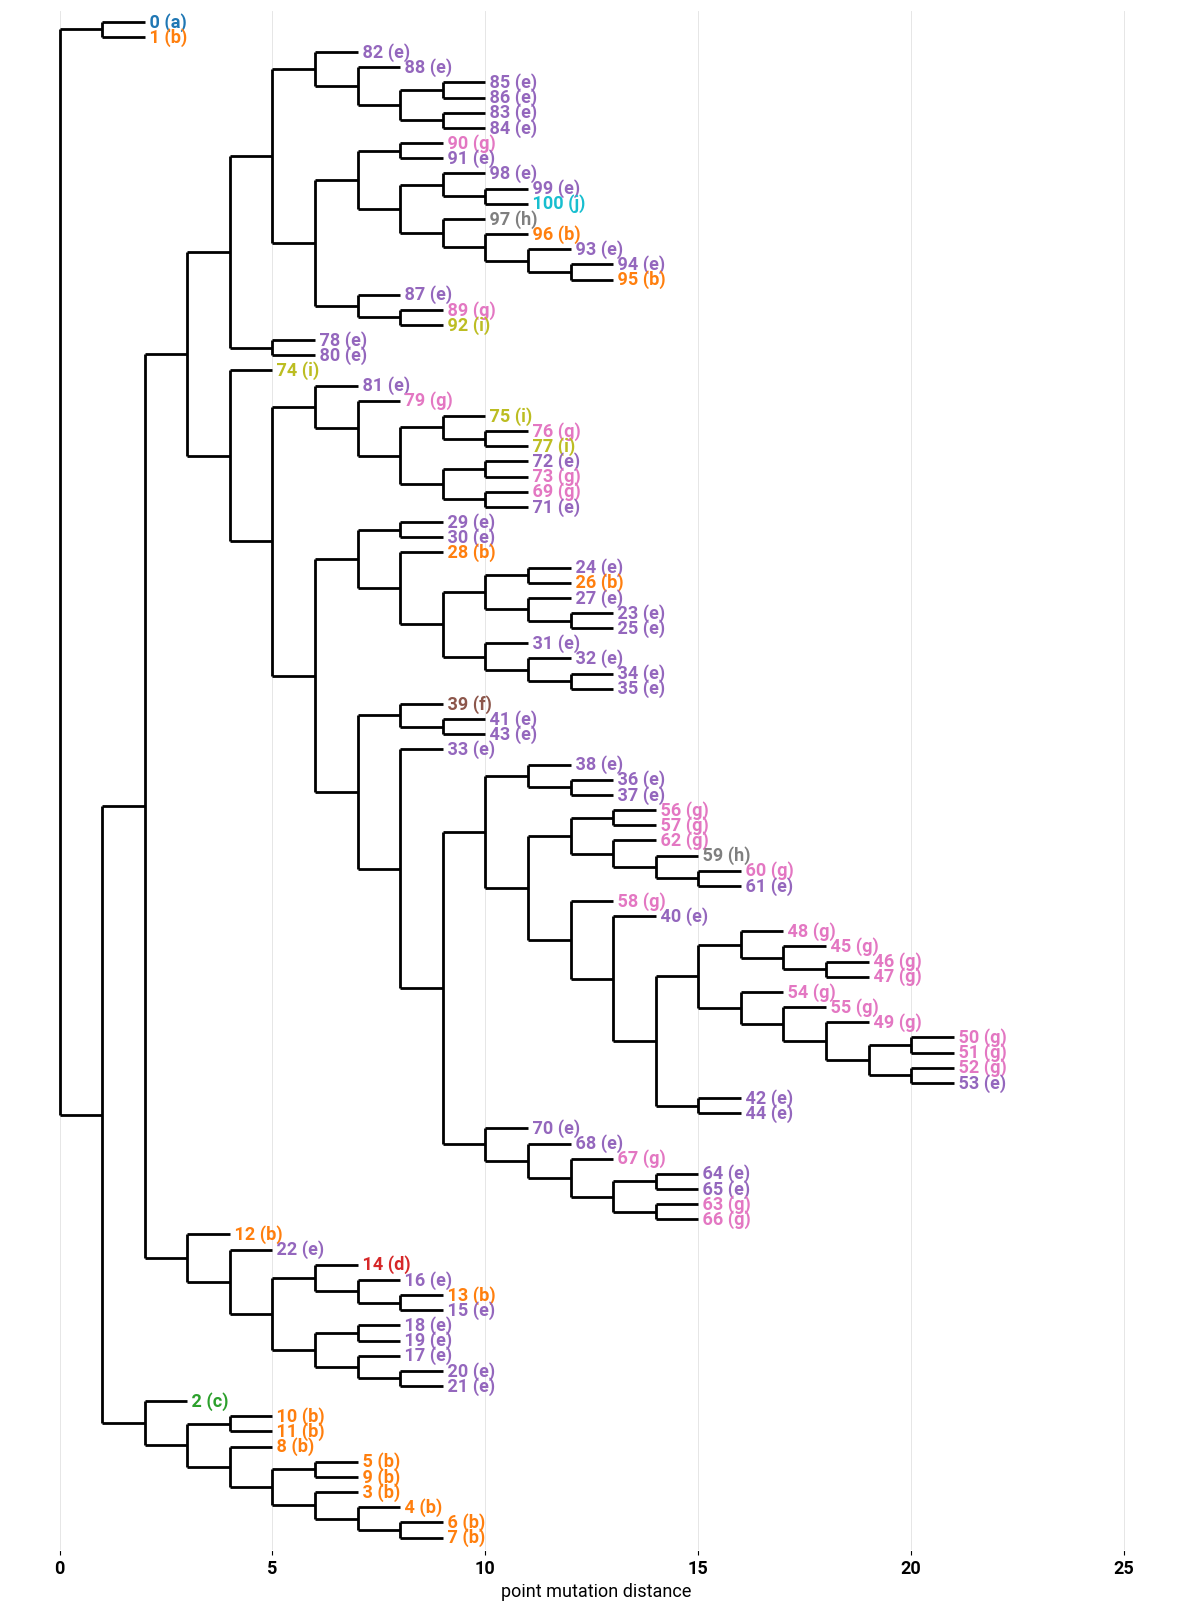

teeplots/scipy_linkage_tree/viz=draw+ext=.pdf
teeplots/scipy_linkage_tree/viz=draw+ext=.png


<Figure size 1500x2000 with 0 Axes>

In [11]:
tp.tee(
    Phylo.draw,
    new_tree,
    label_func=lambda x: x.label if x.is_terminal() else None,
    branch_labels=None,
    label_colors=lambda x: set_color(x),
    xlabel=["point mutation distance"],
    ylabel=[""],
    yticks={"ticks": [0]},
    grid={"visible": True, "which": "both", "axis": "x", "color": "gainsboro", "linewidth": "0.5"},
    teeplot_subdir="scipy_linkage_tree",
    do_show=False,
)